In [1]:
# from kaggle course
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Use GPU support with Tensorflow
# needed to prevent error from using too much gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    


1 Physical GPUs, 1 Logical GPUs


In [2]:
batchsize = 64

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'D:\Datasets\PetImages',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=batchsize,
    shuffle=True,
    validation_split=0.2, # fraction of data to reserve for validation
    subset = "training",
    seed = 31415,
    color_mode = "rgb"
)

ds_valid_ = image_dataset_from_directory(
    'D:\Datasets\PetImages',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=batchsize,
    shuffle=True,
    validation_split=0.2, # fraction of data to reserve for validation
    subset = "validation",
    seed = 31415,
    color_mode = "rgb"
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors(log_warning=True))
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors(log_warning=True))
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [3]:
len(ds_train)

313

In [5]:
class_names = ds_train_.class_names
print(class_names)

['Cat', 'Dog']


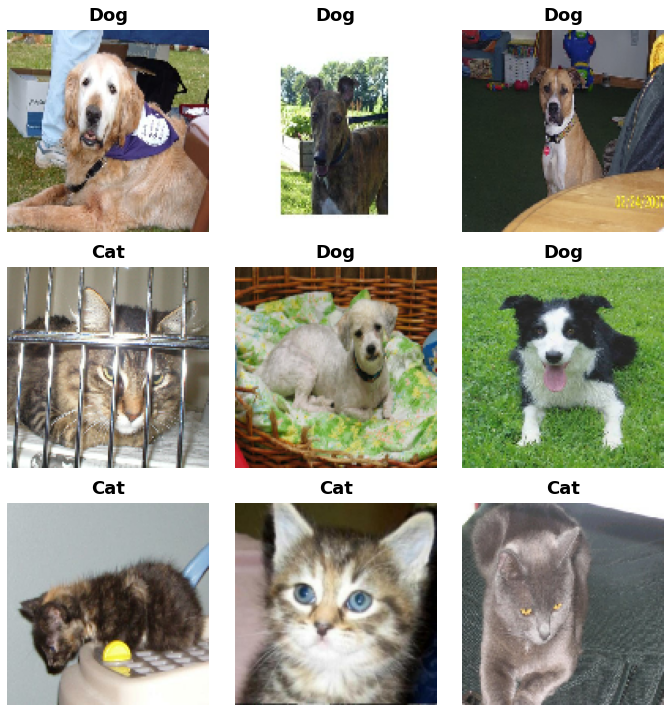

In [6]:
# first images in training set:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_valid.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [7]:
import tensorflow_hub as hub

# Using inception_v1 base
pretrained_base =  hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/4")


In [8]:
# use pre-trained base - called transfer learning
pretrained_base.trainable = False # don't want to train this base as this can cause many changes in weights at the beginning

In [9]:
# Attach head to pre-trained base
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [10]:
# Train
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [20]:
print(ds_train)

<_IgnoreErrorsDataset shapes: ((None, 128, 128, 3), (None, 1)), types: (tf.float32, tf.float32)>


In [11]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_valid,
#     epochs=30,
#     steps_per_epoch = len(ds_train) // 30,
#     validation_steps = len(ds_valid) // 30
# )
for i in range(30):
    model.fit(
        ds_train,
        validation_data=ds_valid, 
        epochs=1,
        verbose=1, 
        steps_per_epoch = len(ds_train),
        validation_steps = len(ds_valid)
    )

217/313 [===================>..........] - ETA: 3s - loss: 0.2430 - binary_accuracy: 0.9631

KeyboardInterrupt: 

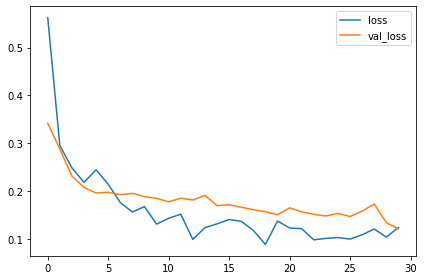

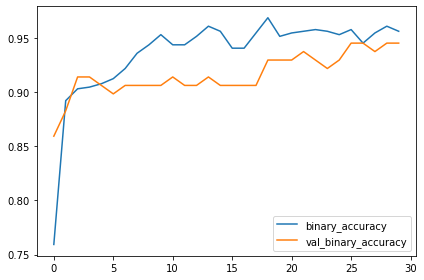

In [61]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [84]:
for e in ds_valid.take(1):
    x = model.predict(np.array(e[0]))
    break

x

array([[8.65962684e-01],
       [7.99883157e-03],
       [9.99997616e-01],
       [1.03925017e-03],
       [9.99990106e-01],
       [2.20020709e-04],
       [9.99909997e-01],
       [9.70394537e-02],
       [9.84455943e-01],
       [2.35633249e-03],
       [5.74264824e-01],
       [9.99880791e-01],
       [9.97400880e-01],
       [9.99916553e-01],
       [9.99988079e-01],
       [1.59391755e-04],
       [3.42742744e-04],
       [4.35945690e-01],
       [9.86135125e-01],
       [2.86564380e-01],
       [9.93738174e-01],
       [1.56979170e-02],
       [7.76187539e-01],
       [9.72695887e-01],
       [9.98251498e-01],
       [9.99815881e-01],
       [2.30267251e-05],
       [5.13130605e-01],
       [9.99984384e-01],
       [9.99940634e-01],
       [9.98119175e-01],
       [9.99974132e-01],
       [8.54808912e-02],
       [9.99277055e-01],
       [9.91690636e-01],
       [3.96861643e-01],
       [2.26484444e-02],
       [1.17758638e-04],
       [1.97910294e-01],
       [1.19215295e-01],


In [ ]:
#kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

plt.figure(figsize=(3,3))
plt.imshow(kernel)